## Import des libraries 

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Import du dataset 

In [2]:
#Importation du dataset à l'aide de la librairie pandas
data = pd.read_csv("data.csv")

#Prévisualilsation du dataset
data

Entreprise               Metier  \
0                                                Sanofi       Data scientist   
1                   Massachusetts General Hospital(MGH)      Data architecte   
2                                                 Delve  Lead data scientist   
3     Ann & Robert H. Lurie Children’s Hospital of C...       Data scientist   
4                                                   Arm       Data scientist   
...                                                 ...                  ...   
9577                Massachusetts General Hospital(MGH)       Data scientist   
9578                            Charles River Analytics       Data scientist   
9579                                     Ball Aerospace       Data scientist   
9580                              Takeda Pharmaceutical       Data scientist   
9581                                             Vertex       Data scientist   

                                           Technologies Diplome Experience  \
0         Matlab/Python/Pyspark/Scikit-learn/Tensorflow  Master          1   
1                             Python/Java/Scala/MongoDB  Master          3   
2     SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...  Master          3   
3                                     C/C++/Java/Python  Master        1,5   
4       Matlab/Python/C++/numpy/Tensorflow/scikit-learn     Phd        NaN   
...                                                 ...     ...        ...   
9577                     C++/R/Python/Matlab/Matplotlib  Master        1,5   
9578     Excel/Python/Matlab/R/machine learning/anglais  Master         11   
9579                       R/machine learning/Excel/VBA  Master          1   
9580    Python/Pyspark/machine learning/Microsoft Azure  Master         17   
9581                                 VBA/Python/Excel/R     Phd          0   

          Ville  
0         Paris  
1     Marseille  
2        Nantes  
3     Marseille  
4      Bordeaux  
...         ...  
9577       Lyon  
9578   Toulouse  
9579      Paris  
9580     Rennes  
9581      Paris  

[9582 rows x 6 columns]

## Première analyse des données

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


### 1) Combien y a t'il d'observations dans ce dataset ? Y a t'il des valeurs manquantes ?
- A l'aide de la fonction ***info()*** on peut avoir une bonne première vue d'ensemble sur le nombre d'observations, les variables, leur type et avoir une première idée de la quantité de valeurs manquantes
- Il y a donc **9582** observations dans ce dataset et **6** variables
- D'après la colonne "Non-Null Count" on peut en effet constater que les colonnes *Entreprise*, *Metier* et *Experience* **possèdent des valeurs manquantes**

In [4]:
#Compte du nombre de valeurs manquantes dans les colonnes concernées 
print("Nombre de valeurs manquantes :\n")
print(
     "Colonne 'Entreprise' :", 
     data.Entreprise.isnull().sum())
print(
     "Colonne 'Metier' :", 
     data.Metier.isnull().sum())
print(
     "Colonne 'Experience' :", 
     data.Experience.isnull().sum())

Nombre de valeurs manquantes :

Colonne 'Entreprise' : 17
Colonne 'Metier' : 19
Colonne 'Experience' : 94


Les données des colonnes *Experience* ne sont pas au bon type de variable. Il faut le modifier pour que les données deviennent traitables

In [5]:
#On remplace les virgules par des points pour pouvoir convertir les str en float
data.Experience = [value.replace(",", ".") if type(value) != float else value for value in data.Experience]

In [6]:
#Conversion du type str en type float
data['Experience'] = data['Experience'].astype(float)

### 2) Imputation des valeurs manquantes pour la variable *Experience*

In [7]:
#Recuperation d'un dataset sans les lignes avec une valeur manquante pour la variable Experience
temp = data.dropna(subset = ['Experience'])

#Recuperation des valeurs pour la colonne Experience dans ce précédent dataset, spécifié aux métiers de data scientist et data engineer
ds_values = temp.loc[temp['Metier'] == 'Data scientist'].Experience
de_values = temp.loc[temp['Metier'] == 'Data engineer'].Experience

In [8]:
#Conservation des valeurs manquantes de la colonne Experience dans un dataset 
missing_values = data['Experience'].isnull()

#Definition des conditions d'imputation 
all_conditions = [
                 (data['Metier'] == 'Data scientist') & (missing_values), 
                 (data['Metier'] == 'Data engineer') & (missing_values)]
fill_with = [
            ds_values.median(), 
            round(de_values.mean(), 1)]

#Remplacement des valeurs manquantes
data['Experience'] = np.select(
                              all_conditions, fill_with, 
                              default = data['Experience'])

### 3) et 4) Nombre moyen d'année d'expérience pour chaque métier

In [9]:
#Création d'un dataframe contenant toutes les valeurs d'années d'expérience groupées par métier
experience_count_df = pd.DataFrame(data['Experience'].groupby(
                                                             by = data['Metier'], 
                                                             sort = False))

#On renomme les colonnes pour plus de visibilité et pour faciliter la manipulation du dataset 
experience_count_df = experience_count_df.rename(
                                                columns = {0: "Metier", 
                                                           1: 'Experience_values'})

In [10]:
#Calcul des valeurs moyenne de chaque liste pour chaque métier 
valeurs_moyennes = [round(series.mean(), 2) for series in experience_count_df.Experience_values]

#Création d'une nouvelle colonne dans le dataset pour afficher ces moyennes
experience_count_df = experience_count_df.assign(Moyenne_annees_experience = valeurs_moyennes)

In [11]:
experience_count_df

Metier                                  Experience_values  \
0       Data scientist  0        1.0
3        1.5
4        2.0
6      ...   
1      Data architecte  1       3.0
8       8.0
12      3.0
13      0....   
2  Lead data scientist  2        3.0
5        6.0
11       3.0
20     ...   
3        Data engineer  9       5.0
10      0.5
15      3.0
18      3....   

   Moyenne_annees_experience  
0                       2.24  
1                       3.00  
2                       3.97  
3                       2.99

Le nombre d'année moyen d'expérience pour chacun des profil correspond aux résultats suivants : 
- Pour le **Data Scientist** : **2.24**
- Pour le **Data Architecte** : **3.00**
- Pour le **Lead Data Scientist** : **3.97**
- Pour le **Data Engineer** : **2.99**

#### Représentation graphique des résultats 

C:\Users\chloe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, "Nombre d'années d'expérience")

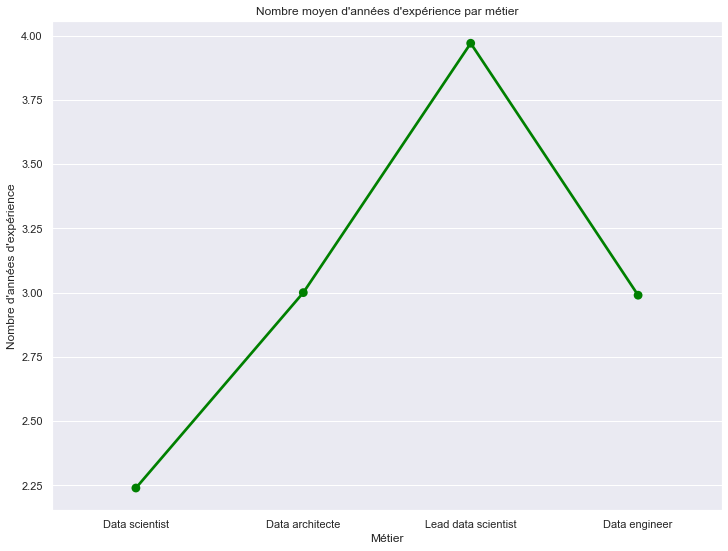

In [12]:
sns.set(rc={'figure.figsize':(12, 9)})
ax = sns.pointplot(
                  experience_count_df["Metier"],  
                  experience_count_df["Moyenne_annees_experience"], 
                  color = 'green')
ax.set_title("Nombre moyen d'années d'expérience par métier")
ax.set_xlabel("Métier")
ax.set_ylabel("Nombre d'années d'expérience")

### 5) Transformation de la variable Experience en variable catégorielle 

#### Première analyse de la distribution des valeurs de la colonne Experience

In [13]:
data.Experience.describe()

count    9540.000000
mean        2.811845
std         2.709302
min         0.000000
25%         1.000000
50%         2.000000
75%         3.500000
max        21.000000
Name: Experience, dtype: float64

In [14]:
distinct_count_df = pd.DataFrame(data.Experience.value_counts())
distinct_count_df.sort_index()

Experience
0.0          899
0.5          916
1.0          996
1.5         1023
2.0         1008
2.5          876
3.0          743
3.5          905
4.0          582
5.0          490
6.0          297
7.0          286
8.0          200
9.0           56
10.0          22
11.0          65
12.0          37
13.0          52
15.0          35
17.0          26
21.0          26

A l'aide de ces deux fonctions on peut constater : 
- Les candidats de la base de données ont des années d'expérience s'étendant de **0 à 21 ans**
- **75% des candidats** de la bdd possèdent des années d'expérience **inférieures ou égales à 3,5**

Pour transformer ces données numériques en catégories on peut donc établir la séparation suivante : 
- de **0 à 3 ans inclus** : *Débutant* 
- de **3 exclu à 7 ans inclus** : *Confirmé* 
- de **7 exclu à 10 ans inclus** : *Avancé* 
- **10 ans exclu et plus** : *Expert*

In [15]:
#Création d'une fonction permettant d'attribuer une catégorie selon une valeur donnée
def mapping_experience(data, column):
        
        #on récupère la valeur de la colonne 
        value = float(data[column])
        
        #Selon la valeur de la colonne (selon le nombre d'année d'expérience), une valeur catégorielle est attribuée
        if value <= 3 :
            return "debutant"
        elif value > 3 and value <= 7 :
            return "confirme"
        elif value > 7 and value <= 10 :
            return "avance"
        else :
            return "expert"

In [16]:
#Application de la fonction à la colonne correspondante 
data['Experience'] = data.apply(
                               mapping_experience, 
                               axis = 1, 
                               column = 'Experience') 

In [17]:
#La commande suivante permet de visualiser le nombre de candidat par catégorie d'expérience 
data.Experience.value_counts()

debutant    6461
confirme    2560
expert       283
avance       278
Name: Experience, dtype: int64

### 6) - Analyse de la variable *Technologies* 

In [18]:
#Impression des données 
data.Technologies.head(10)

0        Matlab/Python/Pyspark/Scikit-learn/Tensorflow
1                            Python/Java/Scala/MongoDB
2    SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...
3                                    C/C++/Java/Python
4      Matlab/Python/C++/numpy/Tensorflow/scikit-learn
5                                   VBA/Python/Excel/R
6                           Excel/VBA/R/Python/PySpark
7                                  Java/C/C++/R/Python
8                                    Java/Linux/Docker
9                                Python/Java/Linux/GNU
Name: Technologies, dtype: object

La colonne *Technologies* contient des string qui liste toutes les technologies en les séparant avec des '/'
Il faut donc effectuer un traitement sur ces valeurs pour séparer les différentes technologies et les rendre traitable pour les manipuler et effectuer des analyses

In [19]:
#Cette variable ne possède pas de valeur manquante, on peut donc directement modifier toutes les valeurs 

#La fonction split permet de séparer la chaine de caractère en liste d'éléments dès qu'elle rencontre le symbole défini. Ici '/'
#Dans l'ensemble de ces données, j'ai pu constater avec d'autres analyses que les données contiennent quelques erreurs : 
# - Certaines valeurs comprennent deux '//' à la suite, il faut les remplacer par un seul pour éviter la création d'une valeur vide.
# - Un oubli de lettre à la fin de "nosq" ce qui compte "nosql" et "nosq" comme 2 groupes différents
# - Les majuscules qui séparent "Machine Learning" et "machine learning"
# - Similarité entre "hadoop(hdfs)" et "hdfs" (doute avec "hadoop" seul ?)

def correction(value):
    
        value = value.lower()
    
        value = value.replace(
                              '//', 
                              '/')
    
        value = value.replace(
                              'hadoop(hdfs)', 
                              'hdfs')
    
        value = value.split('/')
    
        return value

In [20]:
data.Technologies = [correction(value) for value in data.Technologies]
data.Technologies = [['nosql' if value == 'nosq' else value for value in element] for element in data.Technologies]

In [21]:
data.Technologies.head(10)

0    [matlab, python, pyspark, scikit-learn, tensor...
1                       [python, java, scala, mongodb]
2    [spss, sql, teradata, r, python, tensorflow, s...
3                               [c, c++, java, python]
4    [matlab, python, c++, numpy, tensorflow, sciki...
5                              [vba, python, excel, r]
6                     [excel, vba, r, python, pyspark]
7                            [java, c, c++, r, python]
8                                [java, linux, docker]
9                           [python, java, linux, gnu]
Name: Technologies, dtype: object

Le contenu de la variable a été modifié. Il est maintenant devenu plus facile de manipuler les données à l'intérieur.

#### Quelles sont les 5 technologies les plus utilisées ? 

In [22]:
#Création d'un dataframe qui va "éclater" les listes de chaque ligne en transplantant un élément par ligne, en dupliquant l'index du candidat
exploded_data = data.Technologies.explode()

#Comptage des valeurs similaires, et récupération du top 5
top_5_technologies = exploded_data.value_counts().index[:5].tolist()

In [23]:
top_5_technologies

['python', 'r', 'sql', 'java', 'hadoop']

Les 5 technologies les plus utilisées par les candidats sont donc les suivantes : (par ordre décroissant d'utilisation) :
- 1 : **Python**
- 2 : **R**
- 3 : **SQL**
- 4 : **Java**
- 5 : **Hadoop**


In [24]:
#Apercu du total d'utilisation des technologies par les candidats de tout le dataset 
technologies_count = pd.DataFrame(exploded_data.value_counts())
technologies_count = technologies_count.reset_index().rename(
                                                            columns = {'index' : 'Technologies', 
                                                                       'Technologies' : 'Count'})
technologies_count

Technologies  Count
0             python   6627
1                  r   4374
2                sql   2581
3               java   1719
4             hadoop   1589
5   machine learning   1454
6              excel   1398
7                c++   1381
8              spark   1240
9              linux   1183
10           mongodb   1166
11               vba   1003
12               sas    943
13            docker    927
14            matlab    871
15              hive    864
16        tensorflow    848
17     elasticsearch    826
18          big data    824
19      scikit-learn    789
20                 c    739
21            kibana    728
22               aws    691
23               gnu    677
24          teradata    610
25           anglais    603
26           pyspark    593
27              hdfs    459
28              spss    359
29             nosql    355
30   microsoft azure    338
31           mariadb    335
32             scala    310
33         cassandra    284
34        matplotlib    273
35           tableau    250
36           scoring    250
37           vertica    250
38                ai    250
39           pycharm    235
40             kafka    235
41     deep learning    227
42        postgresql    208
43              yarn    206
44        map-reduce    155
45             hbase    155
46               pig    155
47             numpy    140
48          redshift    124
49            oracle     94
50             mysql     94
51           windows     75
52              perl     74
53              ruby     35

In [25]:
#Graphique pour afficher les différentes utilisations par technologies 

#Configuration de la taille du graphique et du choix des couleurs
sns.set(rc={'figure.figsize':(15, 12)})
colors = sns.color_palette('pastel')

#Construction du graphique
ax = sns.barplot(
                technologies_count.Technologies, 
                technologies_count.Count, 
                errwidth = 10, 
                palette = 'pastel')
ax.set_title("Nombre d'utilisation des différentes technologies par les candidats")
ax.set_xlabel("Technologies")
ax.set_ylabel("Nombre d'utilisation")

#Changement du positionnement de l'écriture de la légende l'axe des abscisses pour améliorer la lisibilité
for i, genre in enumerate(ax.get_xticklabels()):
        genre.set_rotation(90)
        genre.set_horizontalalignment('center')
        genre.set_position((i, 0))

C:\Users\chloe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


## Clustering et prédiction

### 7) Clustering non supervisé

Ce dataset est maintenant composé exclusivement de variables catégorielles. Il faut donc les encoder pour permettre aux algorithmes de clustering d'évaluer et de calculer les distances entre les différentes données. 
 
Je vais utiliser deux techniques différentes du fait des 2 formats différents qu'on peut retrouver dans ce dataset : 
 - Pour les colonnes qui contiennent des **string simples**, les **encoder** avec ***LabelEncoder()*** de la librairie *sklearn*. Selon le nombre de valeurs distinctes présentes dans la colonne, le résultat donnera **des entiers entre 0 et nombre_distinct_valeurs - 1**
 - Pour la variable *Technologies* les données sont sous forme de liste. Pour bien séparer les éléments propres à chaque candidat, j'ai utilisé une technique qui **transforme chaque valeur des listes** en une **nouvelle colonne** dans le dataframe, qui contiendra des **valeurs binaires**. Ainsi s**i le candidat a utilisé la technologie en question**, la valeur sera de **1**, et **0 sinon**

In [26]:
data_encoded = data.copy()

In [27]:
#Ce traitement permet d'éliminer les valeurs NaN des colonnes Métier, pour éviter les erreurs pour l'application d'algorithmes de clustering et leur prétaitement
#J'ai pris la décision de supprimer la variable Entreprise, qui possède trop de valeurs distinctes et perturbe l'analyse de clusters
data_encoded = data_encoded.drop('Entreprise', axis = 1)
data_encoded.Metier = ['' if type(value) == float else value for value in data_encoded.Metier]

In [28]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Metier        9582 non-null   object
 1   Technologies  9582 non-null   object
 2   Diplome       9582 non-null   object
 3   Experience    9582 non-null   object
 4   Ville         9582 non-null   object
dtypes: object(5)
memory usage: 374.4+ KB


In [29]:
mlb = MultiLabelBinarizer()
data_encoded = data_encoded.join(pd.DataFrame(mlb.fit_transform(data_encoded.pop('Technologies')),
                          columns=mlb.classes_,
                          index=data_encoded.index))

In [30]:
le = LabelEncoder()


for column in data_encoded.select_dtypes(include=['object']).columns:
        data_encoded[column] = le.fit_transform(data_encoded[column])

In [31]:
data_encoded

Metier  Diplome  Experience  Ville  ai  anglais  aws  big data  c  c++  \
0          3        1           2      8   0        0    0         0  0    0   
1          1        1           2      4   0        0    0         0  0    0   
2          4        1           2      6   0        0    0         0  0    0   
3          3        1           2      4   0        0    0         0  1    1   
4          3        3           2      0   0        0    0         0  0    1   
...      ...      ...         ...    ...  ..      ...  ...       ... ..  ...   
9577       3        1           2      3   0        0    0         0  0    1   
9578       3        1           3     13   0        1    0         0  0    0   
9579       3        1           2      8   0        0    0         0  0    0   
9580       3        1           3      9   0        0    0         0  0    0   
9581       3        3           2      8   0        0    0         0  0    0   

      ...  spark  spss  sql  tableau  tensorflow  teradata  vba  vertica  \
0     ...      0     0    0        0           1         0    0        0   
1     ...      0     0    0        0           0         0    0        0   
2     ...      0     1    1        0           1         1    0        0   
3     ...      0     0    0        0           0         0    0        0   
4     ...      0     0    0        0           1         0    0        0   
...   ...    ...   ...  ...      ...         ...       ...  ...      ...   
9577  ...      0     0    0        0           0         0    0        0   
9578  ...      0     0    0        0           0         0    0        0   
9579  ...      0     0    0        0           0         0    1        0   
9580  ...      0     0    0        0           0         0    0        0   
9581  ...      0     0    0        0           0         0    1        0   

      windows  yarn  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
9577        0     0  
9578        0     0  
9579        0     0  
9580        0     0  
9581        0     0  

[9582 rows x 58 columns]

Le dataset comprend maintenant que des valeurs numériques, ce qui va permettre l'application d'algorithme avec des calculs de distances entre les valeurs des variables, dans le but d'identifier des pattern entre les données et in fine des groupes similaires

#### KModes clustering

Pour le clustering on pense très vite à l'algorithme **KMeans** mais cette méthode **n'est pas adaptée aux variables catégorielles** puisqu'elle se base sur un **calcul de distance entre les points**. Ici toutes les variables sont maintenant catégorielles et l'algorithme **KMode** est utilisé pour créer des **clusters avec des variables catégorielles**. Il utilise les **dissimilarités entre les points de données**.  Plus les **dissemblances sont faibles**, plus nos points de données sont **similaires**.  

- (Il faut d'abord installer kmodes (pip install kmodes dans la console anaconda))

In [34]:
#Lancement de plusieurs itérations de l'algorithme kmode pour chercher le k optimal
cost = []
K = range(1,7)
for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
        kmode.fit_predict(data_encoded)
        cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 60517.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 60517.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 60517.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 60517.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 60517.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3310, cost: 54340.0
Run 1, iteration: 2/100, moves: 432, cost: 54340.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1605, cost: 54426.0
Init: initializing

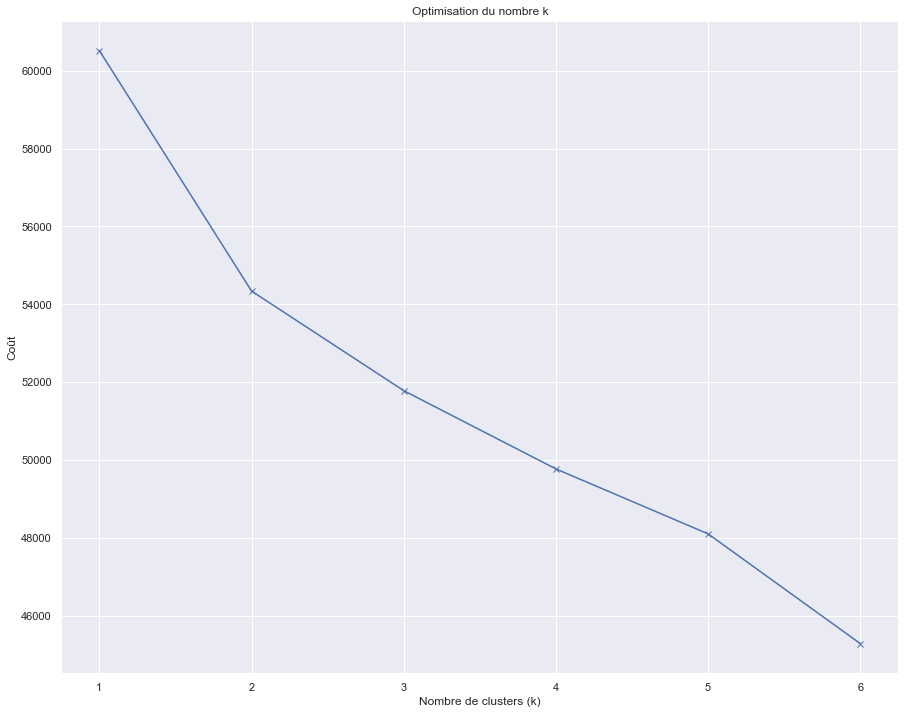

In [35]:
#On visualise le graphique pour mieux se rendre compte du résultat de l'analyse 
plt.plot(K, cost, 'bx-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Coût')
plt.title('Optimisation du nombre k')
plt.show()

La courbe semble se rompre pour **k = 2** on peut donc conserver ce nombre pour la suite 

In [36]:
#On construit le modèle avec k = 2
kmode = KModes(n_clusters= 2, init = "random", n_init = 5, verbose=0)
clusters = kmode.fit_predict(data_encoded)
clusters

array([1, 0, 1, ..., 1, 1, 1], dtype=uint16)

In [37]:
#On crée une nouvelle colonne avec les prédictions de clustering
data_encoded = data_encoded.assign(Cluster = clusters)
data_encoded.Cluster.value_counts()

1    4928
0    4654
Name: Cluster, dtype: int64

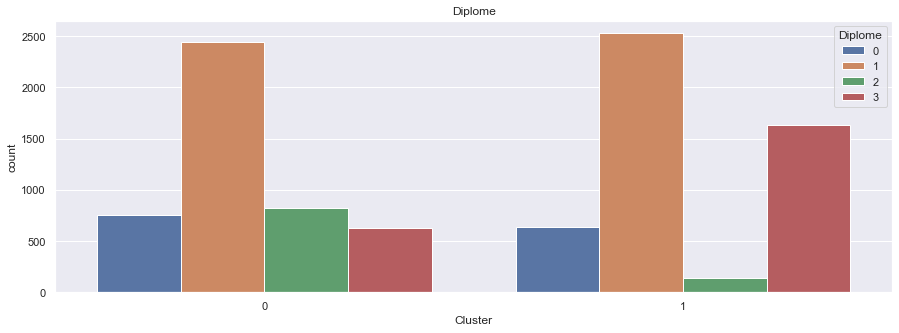

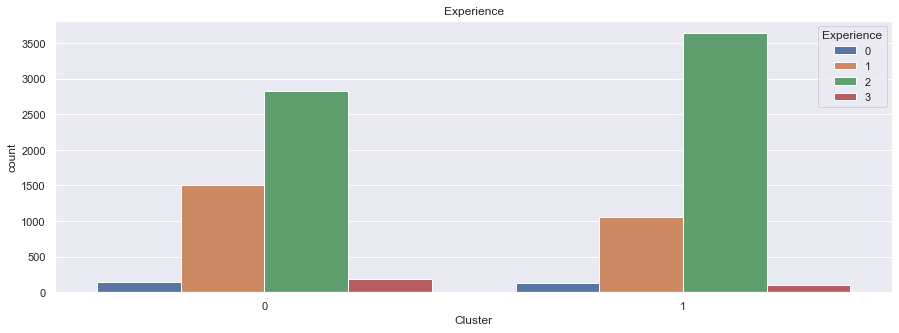

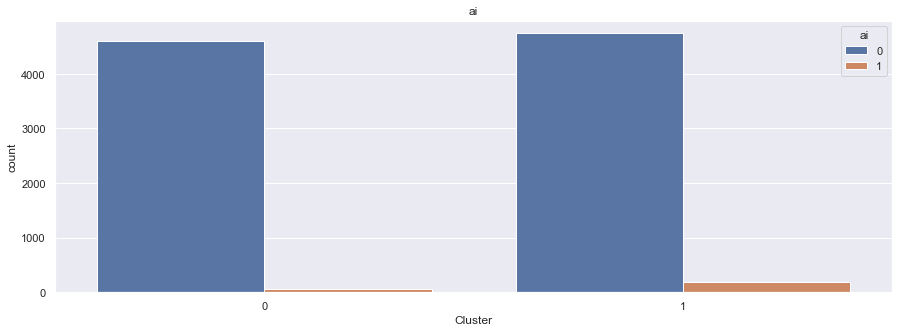

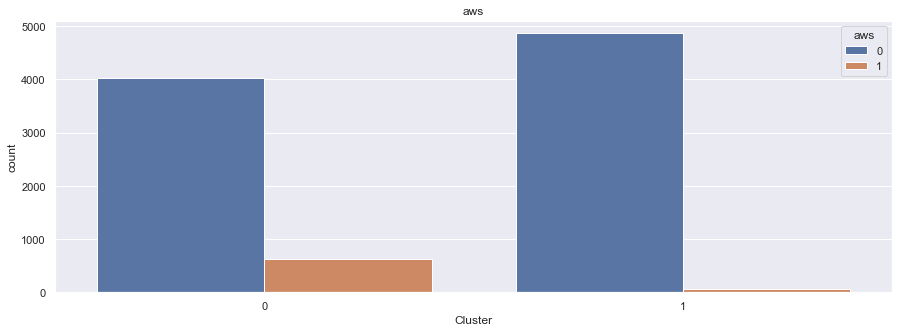

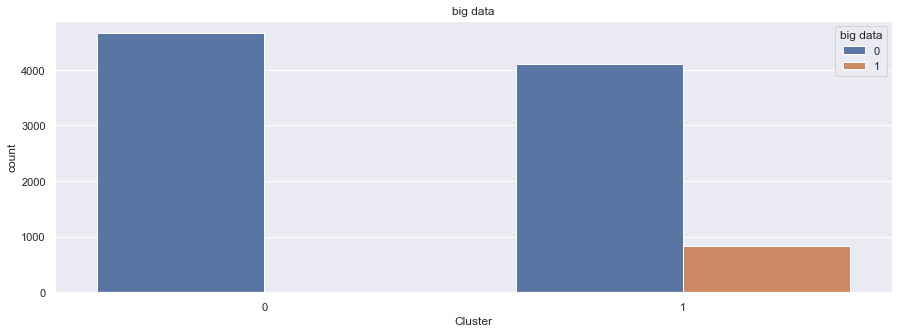

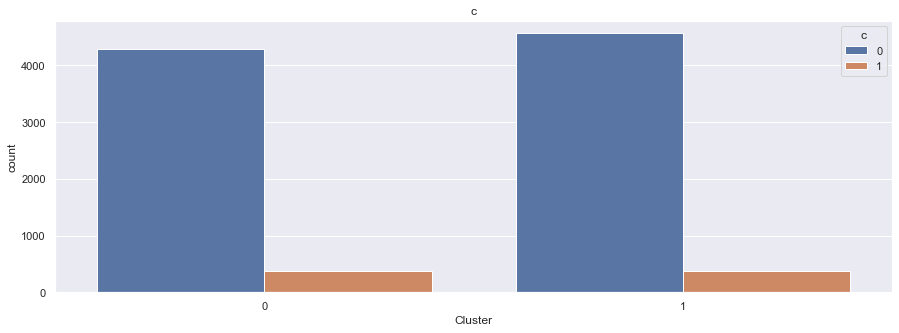

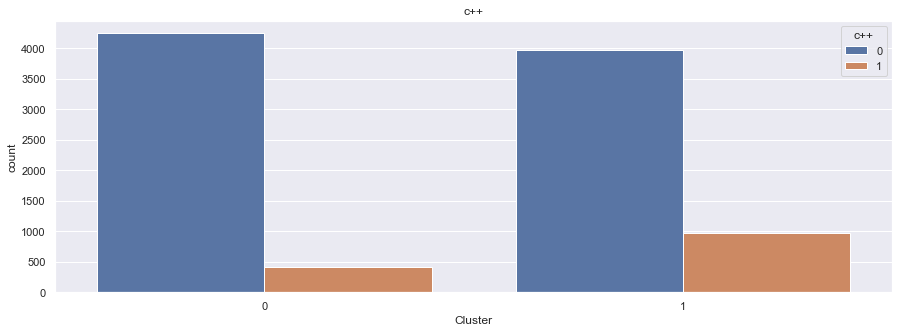

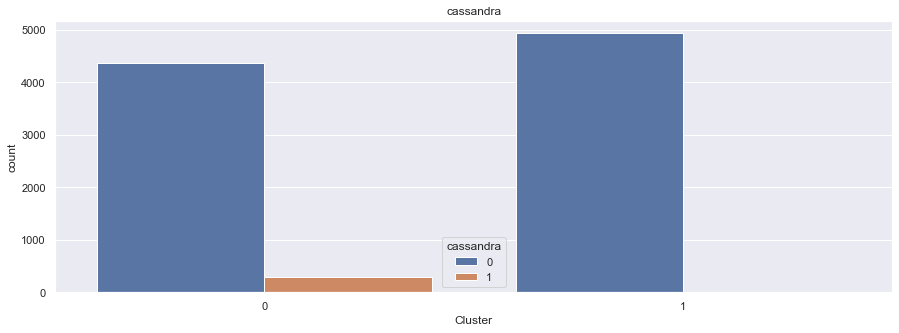

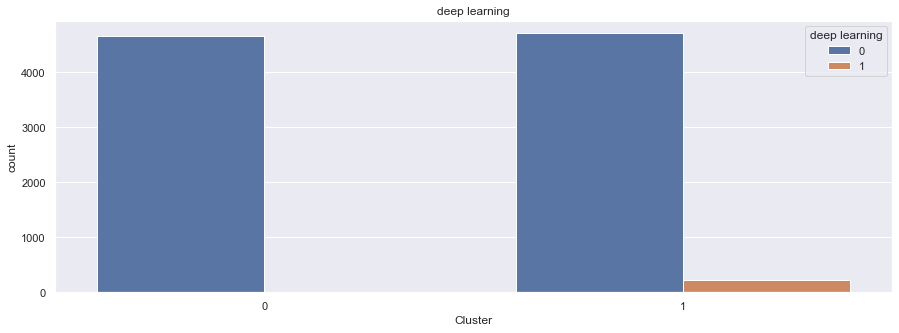

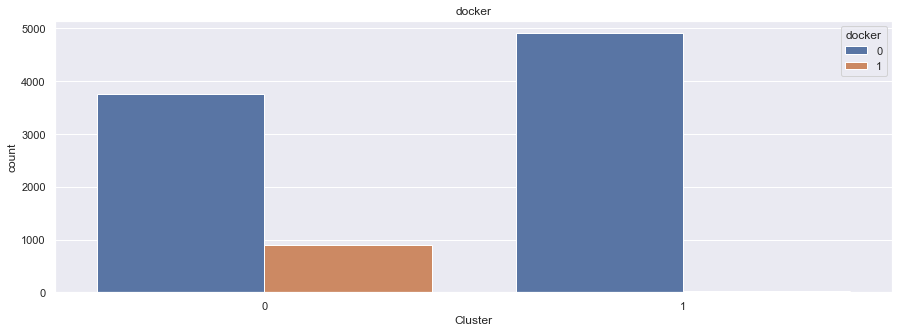

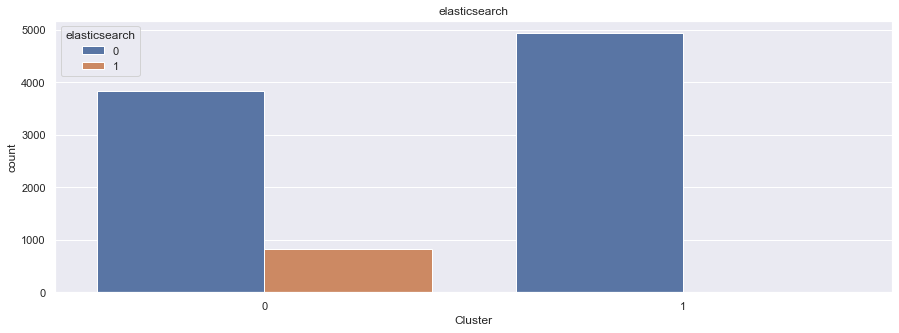

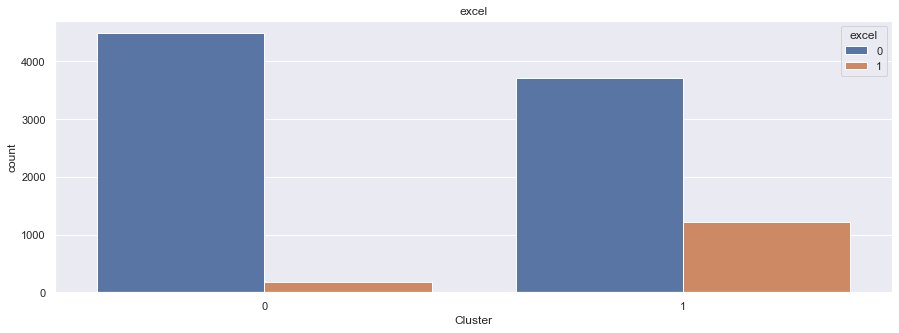

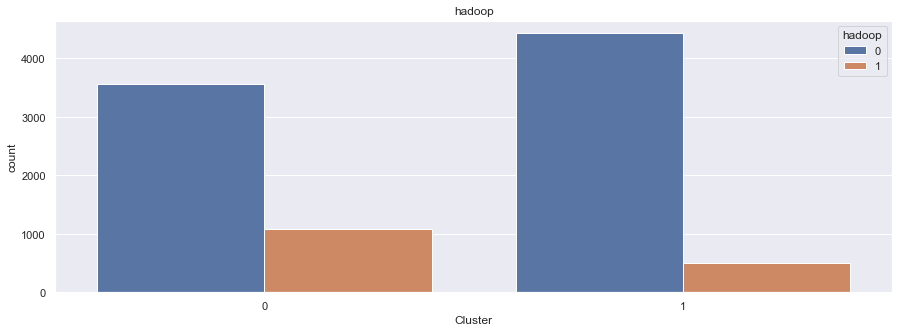

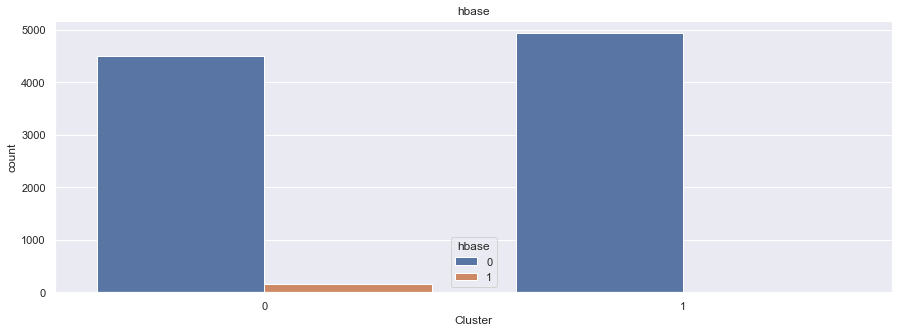

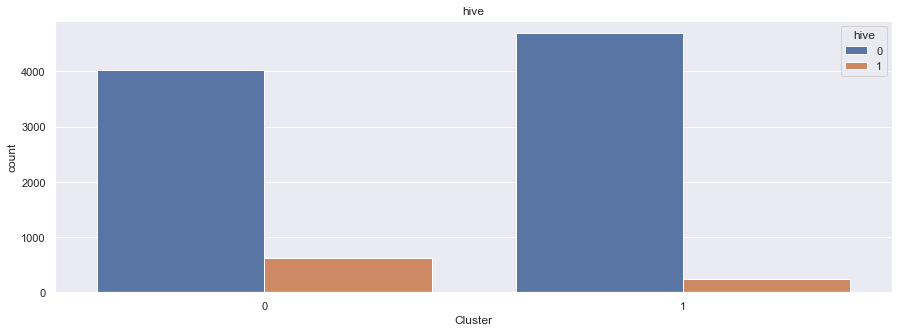

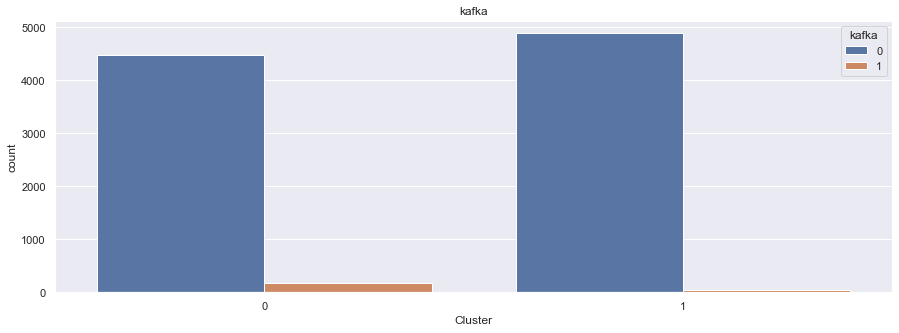

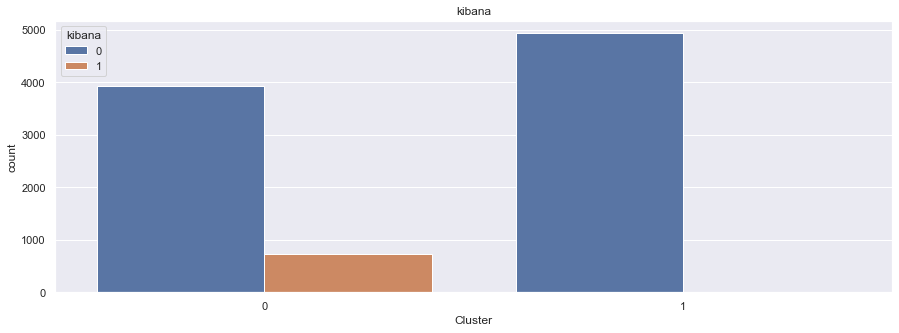

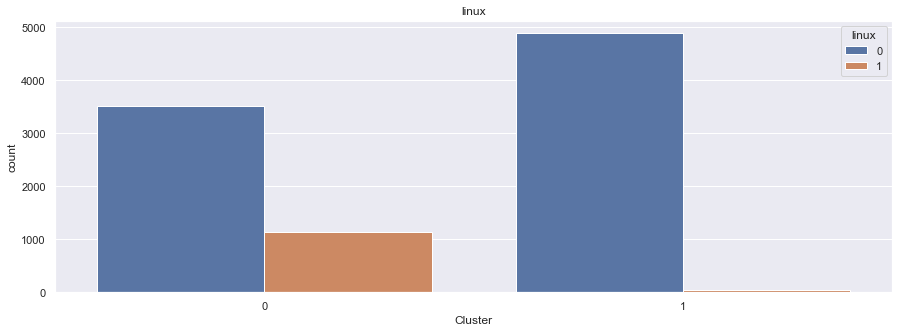

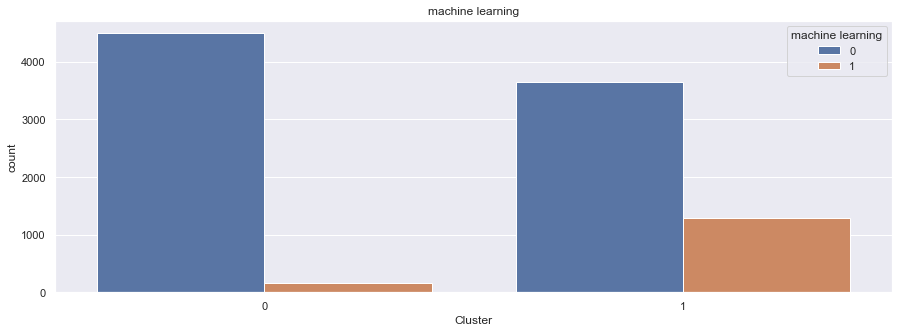

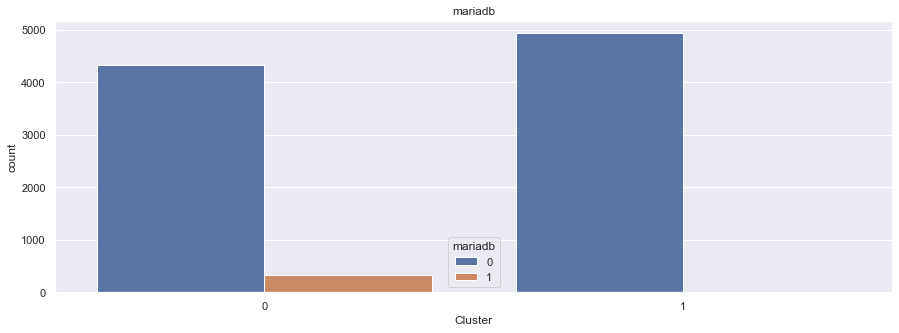

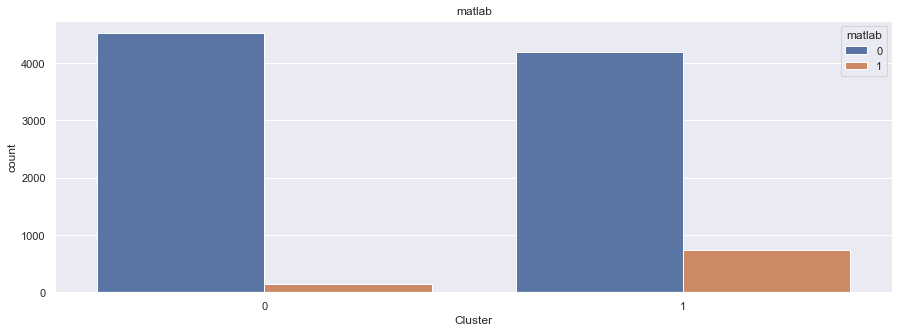

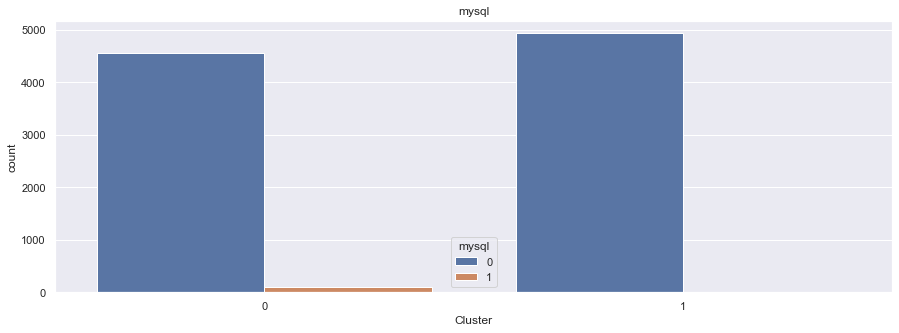

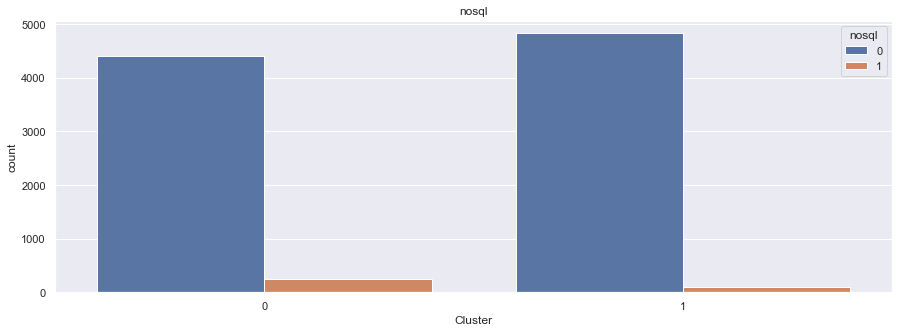

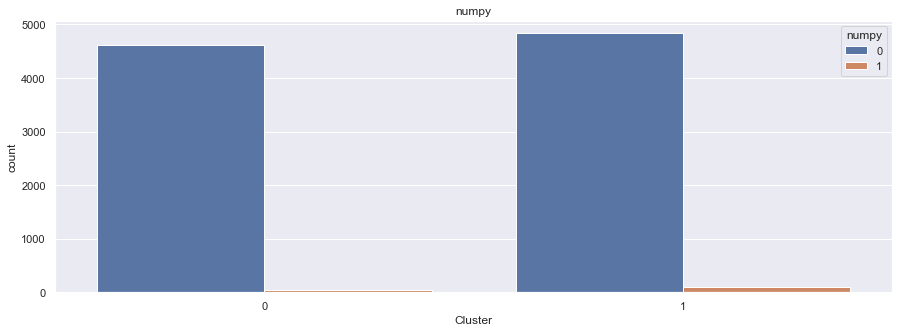

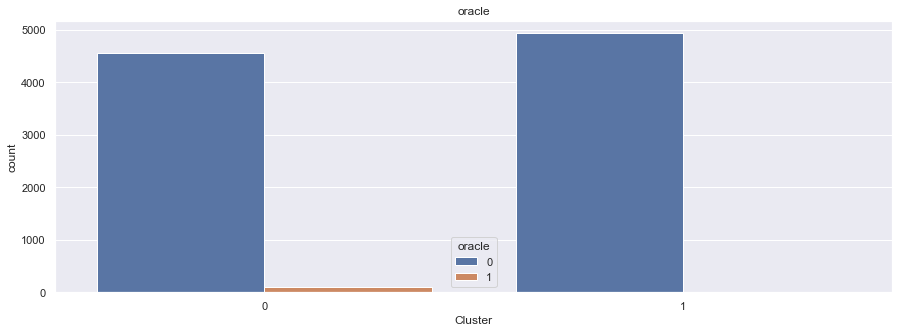

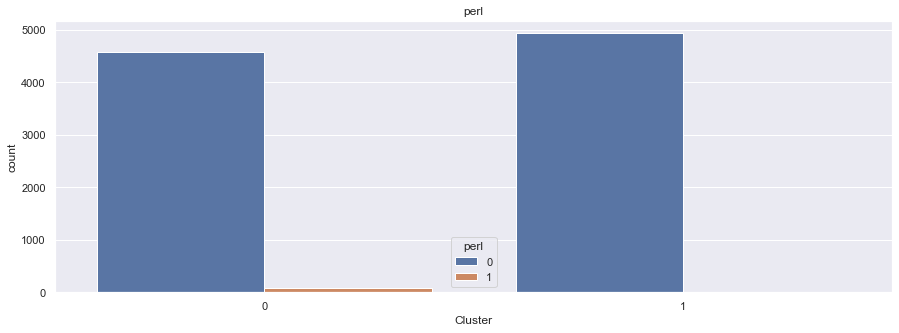

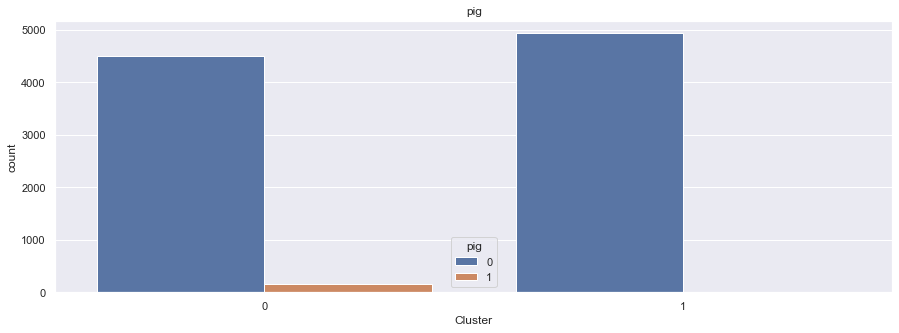

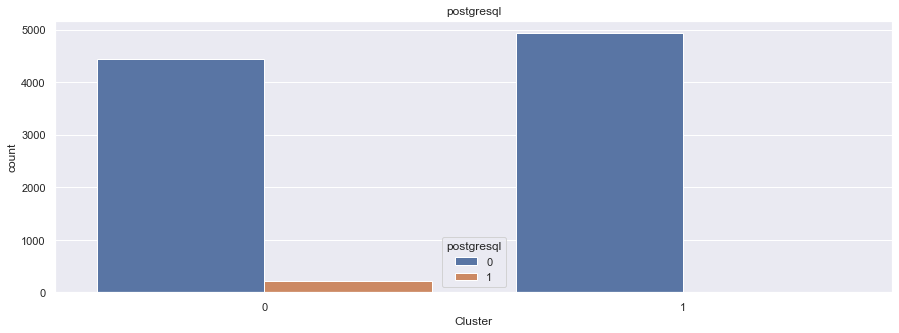

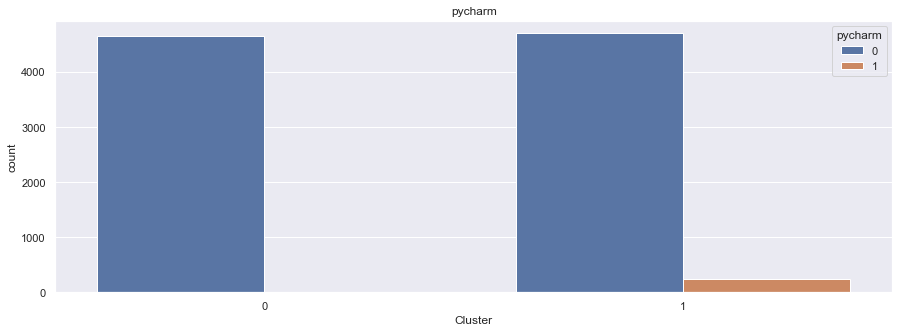

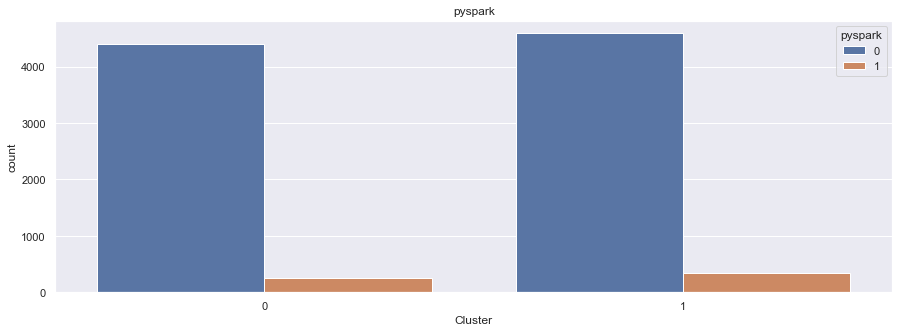

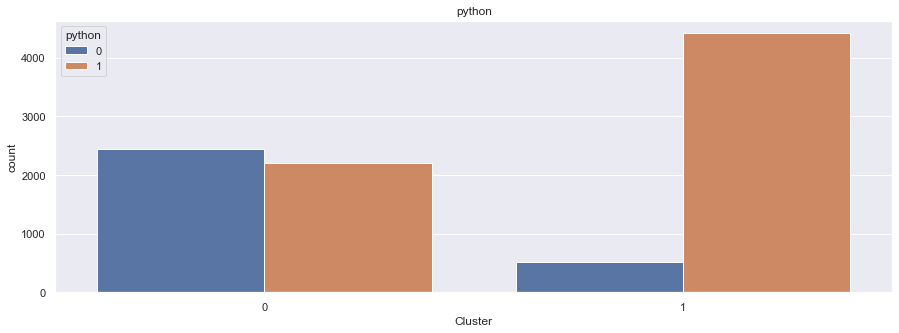

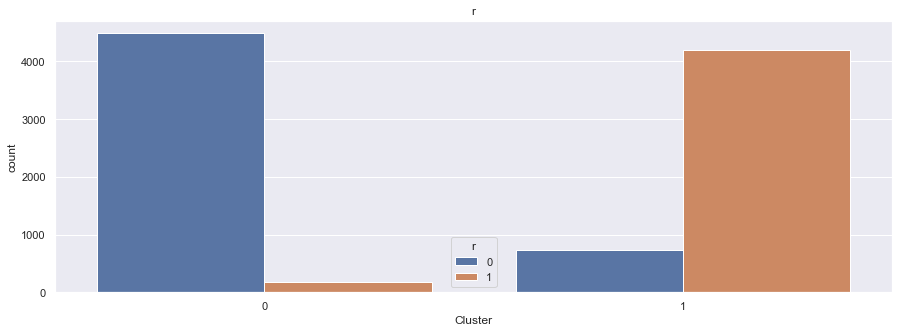

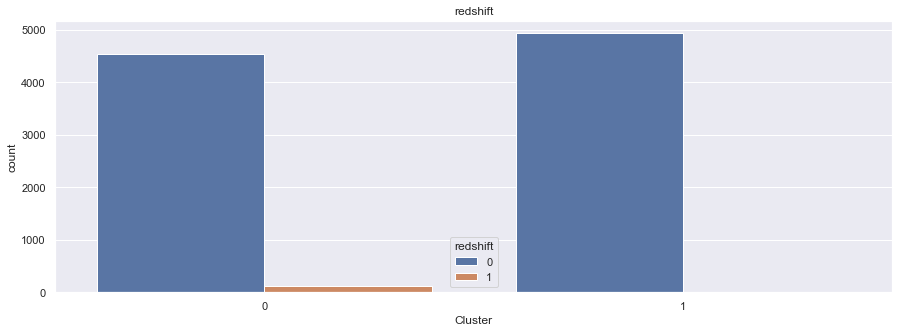

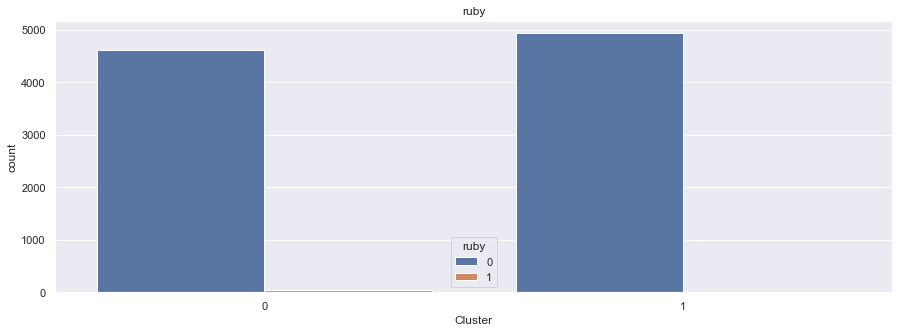

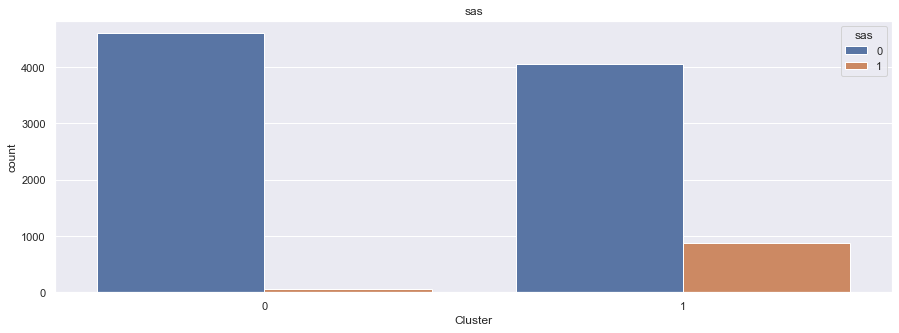

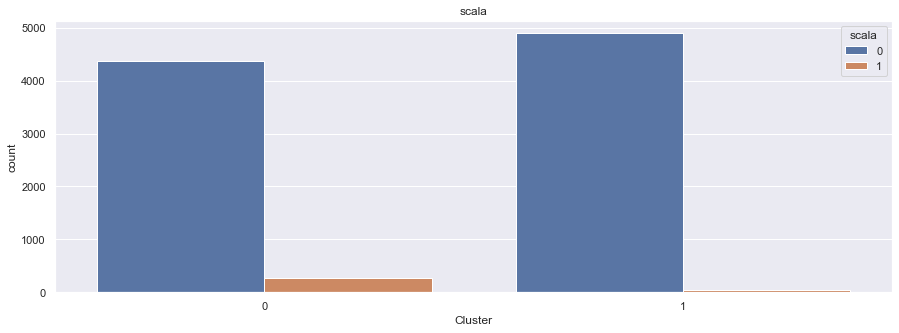

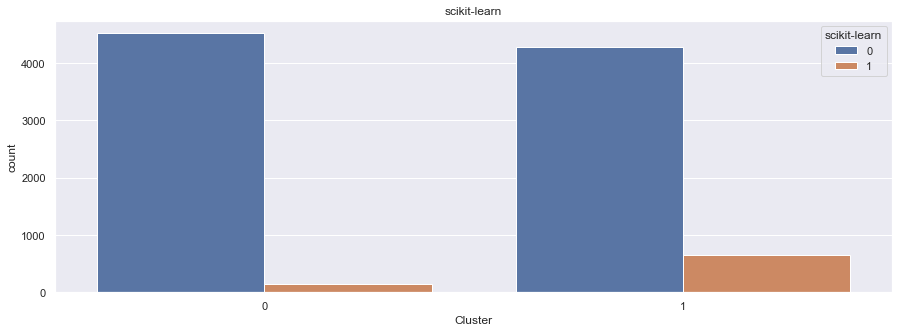

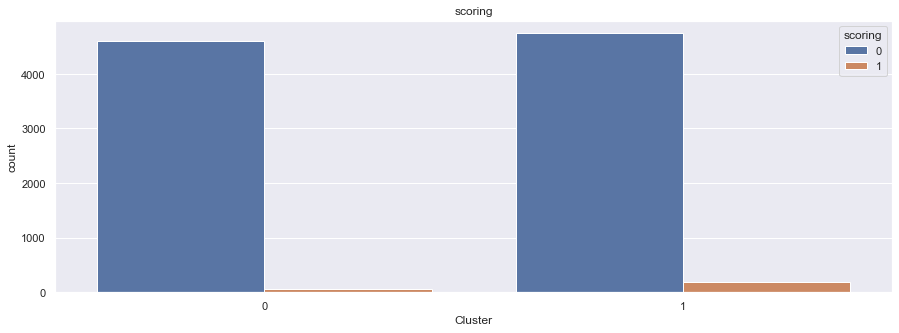

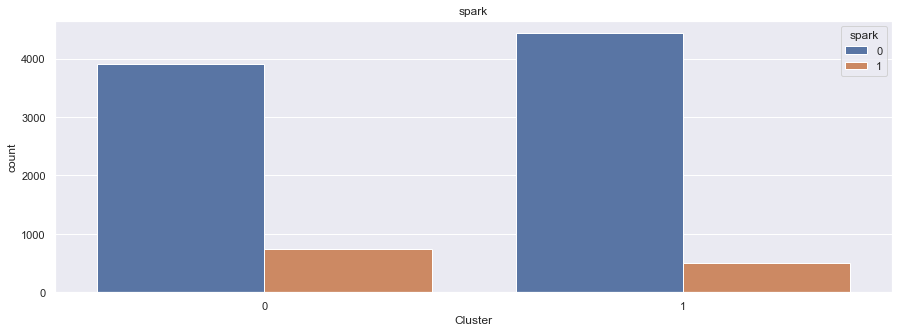

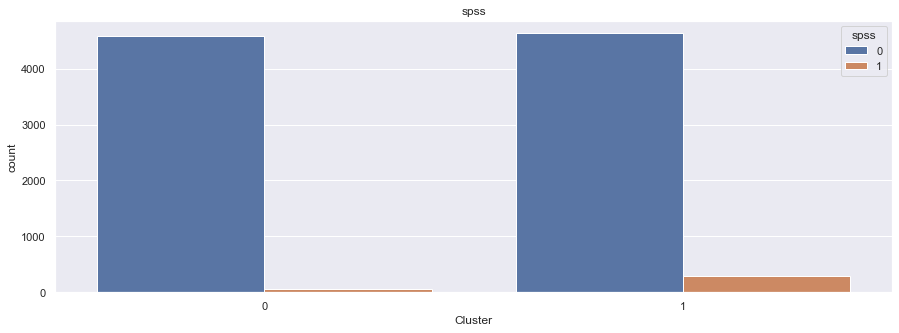

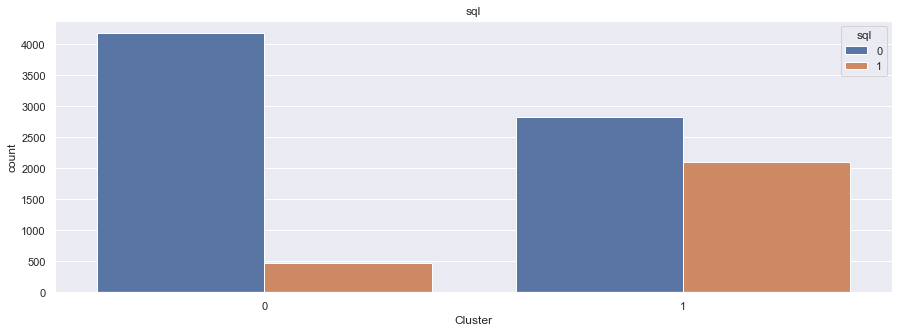

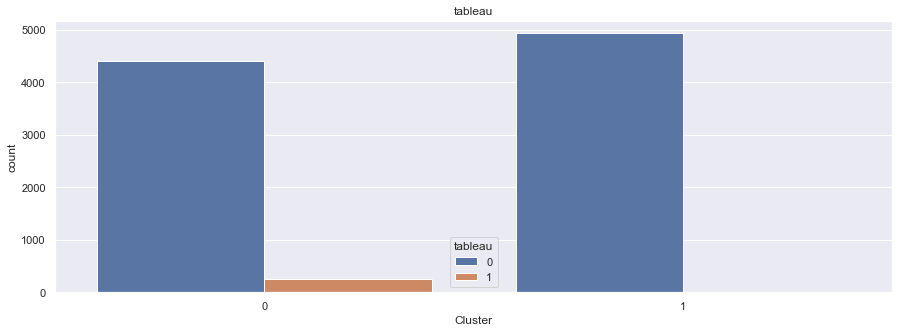

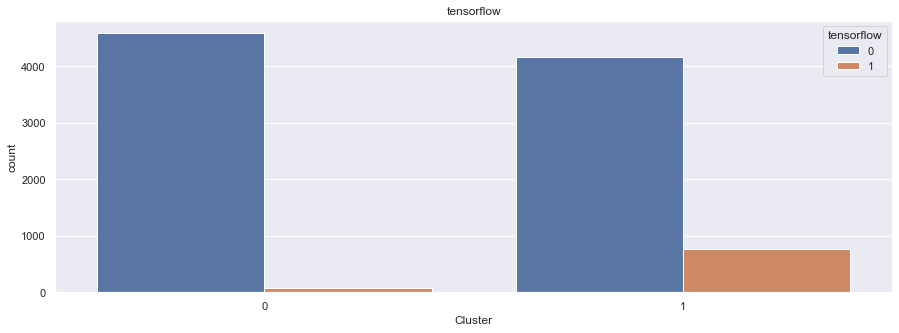

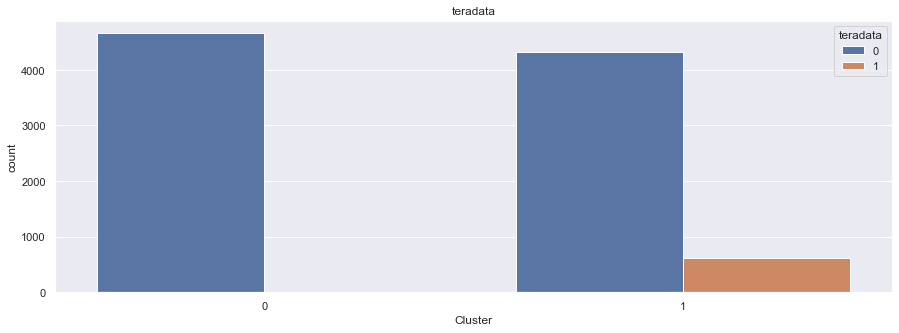

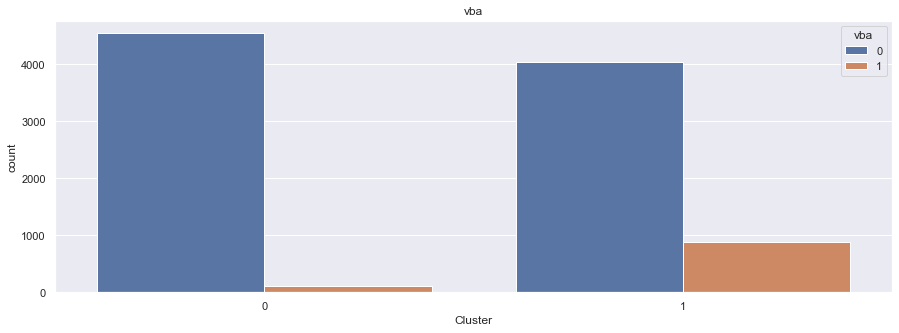

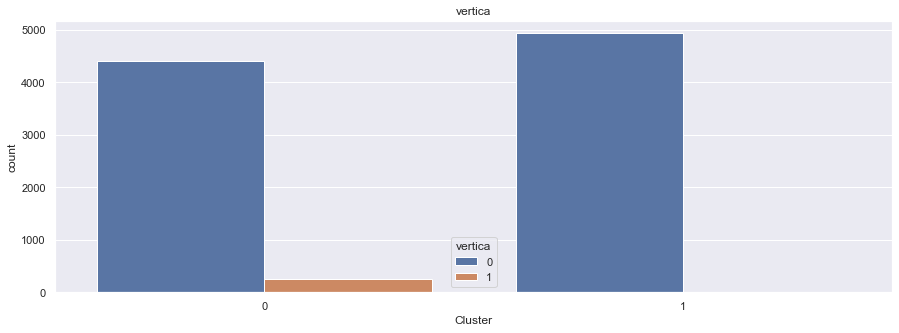

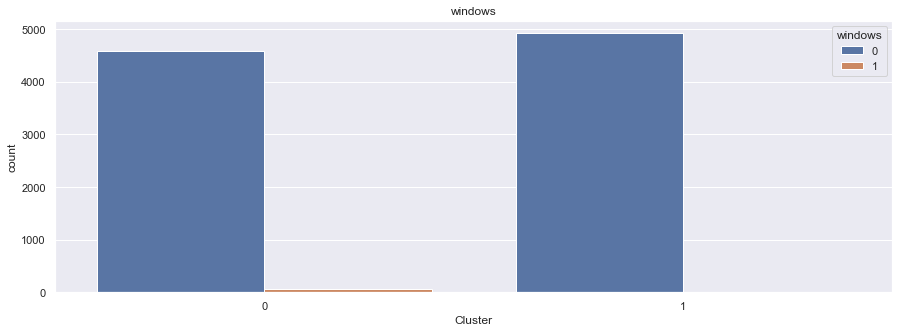

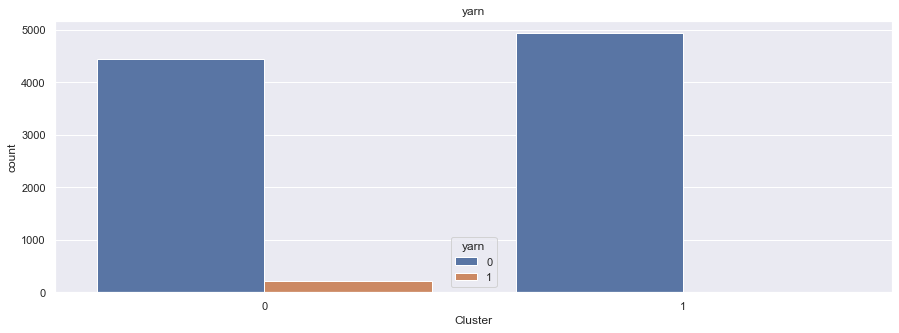

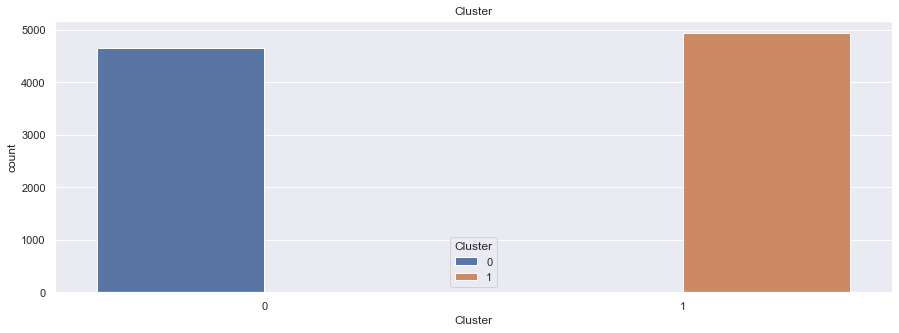

In [38]:
#Cette représentation graphique permet de visualiser les tendances de chacune des variables dans les clusters 
for col in data_encoded.columns:
        plt.subplots(figsize = (15,5))
        sns.countplot(
                     x='Cluster',
                     hue=col, 
                     data = data_encoded)
        plt.title(col)
        plt.show()

D'après l'analyse effectuée à partir de plusieurs itérations de l'algorithme kmode, le **nombre pertinent de clusters** déterminés avec cet ensemble de données serait de **2**. 

En observant plus précisemment les graphiques ci-dessus on peut remarquer les choses suivantes : 
- Pour la variable *Metier*, le modèle a separé les 4 métiers en **deux groupes**, d'un côté les **Data architecte et Data engineer** et de l'autre les **Data scientist et Lead data scientist**.
- Concernant la variable *Diplôme*, la distribution est **assez similaire dans les 2 clusters**, hormis pour le cluster 1 qui semble englober quasiment tous les candidats **"sans diplôme"**
- La distribution pour les variables *Ville* et *Experience* est **similaire pour les 2 groupes***
Toutes les variables suivantes sont associées à **chaque technologie évoquée dans l'ensemble du dataset**, elles sont en général **plus assignées à un cluster que l'autre**. On retrouve ; 
- Pour le cluster 1 : *aws, c, c++, cassandra, docker, elasticsearch, gnu, hadoop, hbase, hdfs, hive, java, kafka, kibana, linux, map-reduce, mariadb, matlab, mongodb, mysql, nosql, numpy, oracle, perl, pig, postgresql, pyspark, python, redshift, scala, scikit-learn, spark, tableau, vertica, windows et yarn*
- Pour le cluster 2 : *ai, anglais, big data, c, c++, deep learning, excel, hadoop, hive, machine learning, matlab, matplotlib, microsoft azure, nosql, pycharm, pyspark, python, r, sas, scikit-learn, scoring, spark, spss, sql, tensorflow, teradata, et vba*
Il semble y avoir **une véritable correlation** entre un **certain nombre de technologies** et les **deux groupes de métiers associés**. 

### 8) Prédiction des métiers manquants

Dans un premier temps, il faut séparer le dataset en 2, avec d'une part les lignes comprenant une valeur pour la colonne 'Métier' et d'autre part les lignes qui ne possède pas de valeur dans cette colonne

In [39]:
data_encoded3 = data.copy()

In [40]:
#Preparation des données pour que les variables catégorielles soient traitables 
#Utilisation du même processus d'encodage que la question précédente

data_encoded3 = data_encoded3.join(pd.DataFrame(
                                               mlb.fit_transform(data_encoded3.pop('Technologies')),
                                               columns=mlb.classes_,
                                               index=data_encoded3.index))

mlb = MultiLabelBinarizer()
le = LabelEncoder()

data_encoded3.Entreprise = ['' if type(value) == float else value for value in data_encoded3.Entreprise]

data_encoded3['Entreprise'] = le.fit_transform(data_encoded3['Entreprise'])
data_encoded3['Diplome'] = le.fit_transform(data_encoded3['Diplome'])
data_encoded3['Experience'] = le.fit_transform(data_encoded3['Experience'])
data_encoded3['Ville'] = le.fit_transform(data_encoded3['Ville'])

In [41]:
#Separation des dataset
data_to_predict = data_encoded3[data_encoded3.Metier.isnull()]
data_encoded3 = data_encoded3.dropna(subset = ['Metier'])

L'encodage pour la colonne métier à été fait comme suit :  (Il s'est effectué par ordre alphabétique)
- 0 = Data architecte
- 1 = Data engineer
- 2 = Data scientist 
- 3 = Lead data scientist

In [42]:
data_encoded3['Metier'] = le.fit_transform(data_encoded3['Metier'])

In [43]:
#Au sein du dataset d'entrainement, il faut maintenant séparer les variables d'entrainement avec la variable target
X = data_encoded3.loc[:, data_encoded3.columns != 'Metier']
y = data_encoded3.Metier

In [44]:
#Séparation du dataset, en set d'entrainement et de test pour permettre d'évaluer la performance du modèle 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#### Random Forest Classifier 
J'ai dédidé d'appliquer cet algorithme pour créer un modèle qui permettra de prédire les métiers manquants
--> Il s'agit d'un modèle puissant de **classification** qui se base sur l'utilisation des **arbres de décision**.

In [45]:
#Initialisation du modèle 
clf = RandomForestClassifier(n_estimators = 500)

#Entrainement du modèle
clf.fit(X_train, y_train)

#Prédictions
y_pred = clf.predict(X_test)

In [46]:
#Calcule de la métrique "accuracy" pour évaluer la performance du modèle 
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))

Accuracy : 0.8574416172882537


Pour la première exécution de cet algorithme, le score du modèle exprimé par la **métrique 'accuracy'** est un **bon score**. 
**Plus** il est **élevé**, **plus** le modèle est **performant**. 
 
On peut maintenant tenter d'**optimiser les paramètres** du modèle à l'aide d'un **Grid Search**. Cela permettra de trouver les **meilleurs combinaisons de paramètres** pour obtenir la **meilleure performance du modèle**. 

In [49]:
#Choix des paramètres à optimiser avec une liste de valeurs possibles qui seront testées
n_estimators = [
               100, 
               300,
               500,
               800, 
               1200]
max_depth = [
            5,
            8,
            15,
            25,
            30]
min_samples_split = [
                    2,
                    5,
                    10,
                    15,
                    100]
min_samples_leaf = [
                   1,
                   2,
                   5,
                   10] 

hyperF = dict(
             n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#Lancement de l'exécution du GirdSearch. Cette méthode va tester différents modèles de RandomForest en combinant les différentes valeurs de paramètres mentionnées ci-dessus
gridF = GridSearchCV(
                    clf, hyperF, cv = 3, 
                    verbose = 1, 
                    n_jobs = -1)

bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 59.2min finished


In [52]:
#Meilleurs paramètres selon le GridSearch 
gridF.best_params_

{'max_depth': 25,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 300}

In [53]:
#On relance l'exécution de l'algorithme Random Forest avec les paramères précedemment sélectionnés 
clf4 = RandomForestClassifier(
                             n_estimators = 300, 
                             max_depth = 25, 
                             min_samples_leaf = 5, 
                             min_samples_split = 10)

clf4.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300)

In [54]:
#Evaluation du dernier modèle créé avec les meilleurs paramètres trouvés par el Grid Search 
y_pred3 = clf4.predict(X_test)
print("Accuracy :", metrics.accuracy_score(y_test, y_pred3))

Accuracy : 0.8825374695015685


Le score de performance du modèle s'est en effet **amélioré** (***0,88***). On peut maintenant tenter de prédire les variables manquantes pour le dataset à prédire

In [55]:
data_to_predict = data_to_predict.drop('Metier', axis = 1)

In [56]:
#Prédiction des métiers manquants pour les données stockées dans le dataset "data_to_predict"
predictions = clf4.predict(data_to_predict)

In [57]:
#Création d'une nouvelle colonne dans le dataset pour stocker les résultats des prédictions
data_to_predict = data_to_predict.assign(Metier_predictions = predictions)
data_to_predict.Metier_predictions

346     1
2058    2
2670    2
2899    2
3346    0
4248    2
4290    2
4292    3
5425    1
5593    2
5712    0
6024    1
6625    0
7091    2
7228    1
7330    2
9087    0
9427    2
9490    2
Name: Metier_predictions, dtype: int32

A partir de l'encodage précédent réalise sur la colonne *Metier*, on peut **inverser l'action** et réécrire les **noms de métier** correspondants

In [58]:
#Mapping de la colonne Metier_predictions pour une meilleure visibilité sur les métiers prédis
metiers = {
          0 : 'Data architecte',
          1 : 'Data engineer',
          2 : 'Data scientist',
          3 : 'Lead data scientist'}

data_to_predict.Metier_predictions = data_to_predict.Metier_predictions.map(metiers)

In [59]:
data_to_predict.Metier_predictions.value_counts()

Data scientist         10
Data engineer           4
Data architecte         4
Lead data scientist     1
Name: Metier_predictions, dtype: int64

Par rapport à la distribution des métiers présent dans l'ensemble du dataset, la **répartition obtenue dans la prédiction semble cohérente**